In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cv2
import xraylib
import random
import scipy.ndimage as ndimage
import tifffile

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]
import numpy as np
%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension
ne = 256
ntheta = 1  # number of angles (rotations)

pn = 64  # tomography chunk size for GPU processing
ptheta = 1 # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size
energy = 33.35  # [keV] xray energy
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
focusToDetectorDistance = 1.28
ndist = 4
sx0 = 3.7e-4
# z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1[:] = z1[0]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 10e-3# positions of the probe and code for reconstruction
z2p = z1-z1p
# magnification when propagating from the probe plane to the detector
magnificationsp = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/z1

norm_magnificationsp = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnificationsp**2
distancesp = distancesp*(z1p/z1)**2

print(distances, distancesp)
print(distances+ distancesp)


[0.00420013] [-0.00243822]
[0.00176191]


## Form a siemens star

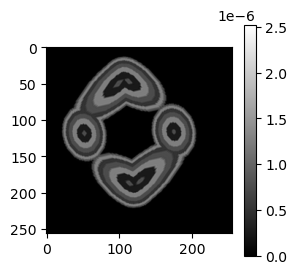

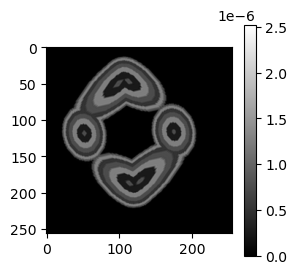

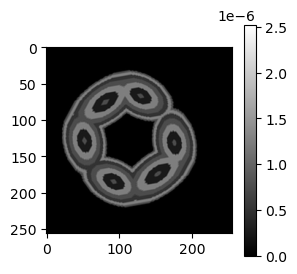

In [3]:
from cupyx.scipy import ndimage
import cupy as cp

cube_all = cp.zeros([n,n,n],dtype='float32')
rr = (cp.ones(8)*n*0.34).astype(cp.int32)
amps = [3, 2, -3, 1, 2,-4,2]#, -2, -4, 5 ]
dil = [30, 28, 25, 21, 16,10,3]#, 6, 3,1]
for kk in range(len(amps)):
    cube = cp.zeros([n,n,n],dtype='bool')
    r = rr[kk]
    p1 = n//2-r//2
    p2 = n//2+r//2
    for k in range(3):    
        cube = cube.swapaxes(0,k)
        cube[p1:p2,p1,p1] = True
        cube[p1:p2,p1,p2] = True
        cube[p1:p2,p2,p1] = True
        cube[p1:p2,p2,p2] = True        
        #cube[p1:p2,p2,p2] = True        
        
    [x,y,z] = cp.meshgrid(cp.arange(-n//2,n//2),cp.arange(-n//2,n//2),cp.arange(-n//2,n//2))
    circ = (x**2+y**2+z**2)<dil[kk]**2        
    fcirc = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(circ)))
    fcube = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(cube.astype('float32'))))
    cube = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(fcube*fcirc))).real
    cube = cube>1
    cube_all+=amps[kk]*cube

cube_all = ndimage.rotate(cube_all,52,axes=(1,2),reshape=False,order=3)
cube_all = ndimage.rotate(cube_all,38,axes=(0,1),reshape=False,order=3)
cube_all = ndimage.rotate(cube_all,10,axes=(0,2),reshape=False,order=3)
cube_all[cube_all<0] = 0



u0 = (-1*cube_all*1e-6+1j*cube_all*1e-8)/4
u0=np.roll(u0,-15,axis=2)
u0=np.roll(u0,-10,axis=1)
v = cp.arange(-n//2,n//2)/n
[vx,vy,vz] = cp.meshgrid(v,v,v)
v = cp.exp(-2*(vx**2+vy**2+vz**2))
fu = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(u0)))
u0 = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(fu*v))).astype('complex64')

u = u0.astype('complex64').get()

fig, ax = plt.subplots(1, figsize=(3, 3))#fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-u0[n//2].real.get(),cmap='gray',vmax=2.526992e-06,vmin=0)
plt.colorbar()
plt.show()
# # sss

fig, ax = plt.subplots(1, figsize=(3, 3))#fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-u0[n//2].real.get(),cmap='gray',vmax=2.526992e-06,vmin=0)
plt.colorbar()
plt.show()

fig, ax = plt.subplots(1, figsize=(3, 3))#fig, ax = plt.subplots(1, figsize=(3, 3))
plt.imshow(-u0[:,n//2-8].real.get(),cmap='gray',vmax=2.526992e-06,vmin=0)
plt.colorbar()
plt.show()
# fig, ax = plt.subplots(1, figsize=(3, 3))
# plt.imshow(u0[n//2].imag.get(),cmap='gray')
# plt.colorbar()
# plt.savefig('figs/betah_rot.png',dpi=300,bbox_inches='tight')
# plt.show()
# fig, ax = plt.subplots(1, figsize=(3, 3))
# plt.imshow(-u0[:,n//2].real.get(),cmap='gray',vmax=2.526992e-06,vmin=0)
# plt.colorbar()
# plt.savefig('figs/deltav_rot.png',dpi=300,bbox_inches='tight')
# plt.show()
# fig, ax = plt.subplots(1, figsize=(3, 3))
# plt.imshow(u0[:,n//2].imag.get(),cmap='gray')
# plt.colorbar()
# plt.savefig('figs/betav_rot.png',dpi=300,bbox_inches='tight')
# plt.show()



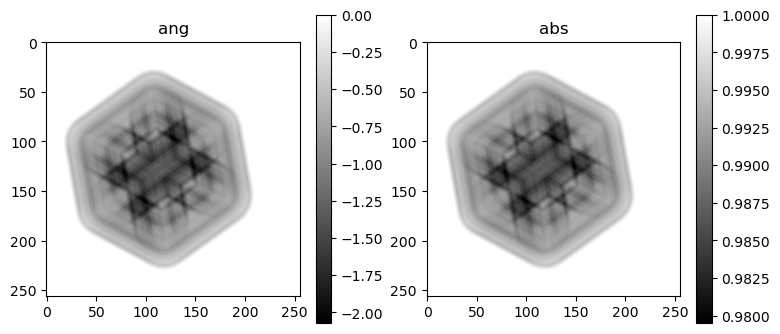

In [4]:
tslv = holotomo.SolverTomo(theta, ntheta, n, n, pn, center)
pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp)
Ru = tslv.fwd_tomo_batch(u)
psi = pslv.exptomo(Ru)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.angle(psi[0]),cmap='gray')
axs[0].set_title('ang')
fig.colorbar(im)
im=axs[1].imshow(np.abs(psi[0]),cmap='gray')
axs[1].set_title('abs')
fig.colorbar(im)

0.42140000000000005
32
[0.00420013] [-0.00243822]


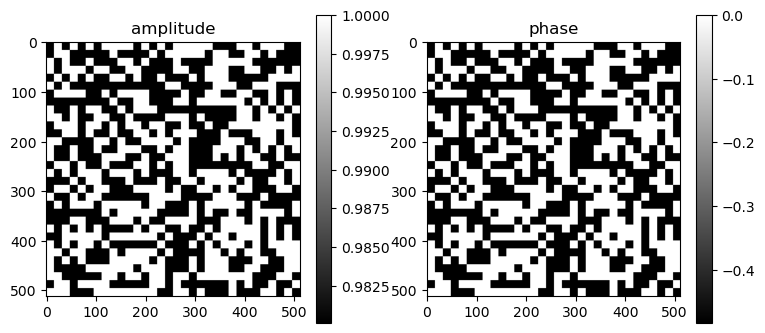

In [5]:
# make some large global code first
from scipy import ndimage
random.seed(10)
nill = 2**11
ill_global = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill_global.shape[0]):
    ill0 = np.zeros([nill*nill],dtype='bool')
    ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
    ill0[ill_ids] = 1
    ill_global[k] = ill0.reshape(nill,nill)

# form codes for simulations
ill_feature_size = 3e-6
print(magnificationsp[0])
nill = int(2*n*voxelsize/magnificationsp[0]//(ill_feature_size*2))*2
print(nill)
ill = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
ill = ndimage.zoom(ill,[1,2*n/nill,2*n/nill],order=0,grid_mode=True,mode='grid-wrap')

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 1*1e-6/voxelsize # thickness in pixels

# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
psiill = np.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psiill[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psiill[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)
print(distances,distancesp)



## Form tranmistance function for the code made of gold with 1um feature size, and 3um thickness

In [6]:
shifts_code = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/8

## Read one probe

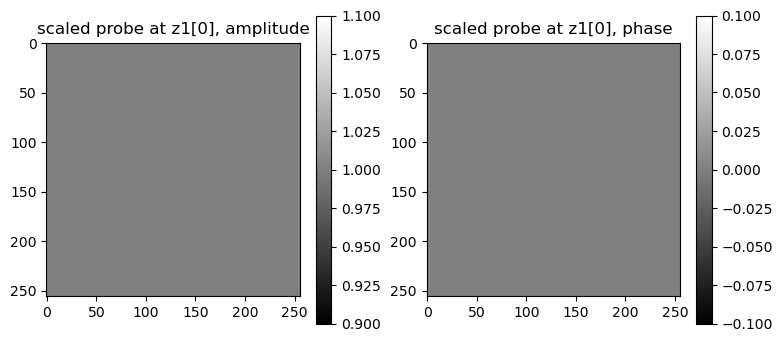

In [7]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[0:ndist]
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[0:ndist]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')  
prb[:] = 1#prb[0]

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)


## Create a solver class for holography, note the class has additional parameters distancesp to be able to compute Fresnel propagation between the sample and probe

In [8]:
pslv = holotomo.SolverHolo(ntheta, n,ne, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp)

## Model data

In [9]:
shifts = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/16*0#*norm_magnifications[:,np.newaxis,np.newaxis]
shifts_ref = shifts/norm_magnifications[:,np.newaxis,np.newaxis]
fpsi = pslv.fwd_holo_batch(psi,prb,shifts_ref,psiill,shifts_code)
fpsi0 = pslv.fwd_holo_batch(psi,prb*0+1,shifts_ref,psiill,shifts_code) # ignore probe

pslv0 = holotomo.SolverHolo(1, n,ne, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distancesp[:1]) 
fref = pslv0.fwd_holo_batch(psi*0+1,prb,shifts_ref[:1,:1]*0,psiill,shifts_code[:1,:1]*0) # ignore sample

## Take squared absolute value to simulate data on the detector, flat fields, and data with homogeneous flat fields  

In [10]:
data = np.abs(fpsi)**2
data_ref = np.abs(fref)**2

## Show data and flat fields for different codes

In [11]:
# fig, axs = plt.subplots(2, 2, figsize=(9, 9))
# im=axs[0,0].imshow(data[3,0],cmap='gray')
# axs[0,0].set_title('data, code=0')
# fig.colorbar(im)
# im=axs[0,1].imshow(data_ref[0,0],cmap='gray')
# axs[0,1].set_title('flat, code=0')
# fig.colorbar(im)
# im=axs[1,0].imshow(data[-1,0],cmap='gray')
# axs[1,0].set_title('data, code=-1')
# fig.colorbar(im)
# im=axs[1,1].imshow(data_ref[-1,0],cmap='gray')
# axs[1,1].set_title('flat, code=-1')
# fig.colorbar(im)
# plt.figure()
# plt.plot(data_ref[0,0,n//2])


# Save data and flat fields

In [12]:
for k in range(len(distances)):
    print(np.linalg.norm(data[k]))
    dxchange.write_tiff(data[k],f'data/modeling/data_siemens_codes_{n}_{k}',overwrite=True)
    dxchange.write_tiff(data_ref[0,0],f'data/modeling/ref_siemens_codes_{n}_0',overwrite=True)
dxchange.write_tiff(psi[0,0],f'data/modeling/psi_siemens_{n}_0',overwrite=True)


dxchange.write_tiff(np.abs(psiill),f'data/modeling/psiill_abs_{n}',overwrite=True)
dxchange.write_tiff(np.angle(psiill),f'data/modeling/psiill_angle_{n}',overwrite=True)

np.save('shifts',shifts)
np.save('shifts_code',shifts_code)


251.39656
